<a href="https://colab.research.google.com/github/delsner/affective-computing-audio/blob/master/05_15_2019_Affective_Computing_Audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Affective Computing: Working with Audio Data

## Speech Recognition

As other domains of machine learning, automatic voice recognition and speech synthesis has improved a lot through the advances in deep learning research in the past decade. Prominent examples are the voice assistant *Google Duplex* or speech recognition systems listening on hot words such as *Hey Siri* or Amazon's *Alexa*.

In [0]:
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/D5VN56jQMWM?start=180" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

## The Modality Audio

Working with audio data has been a large research field in areas such as computer science, electrical engineering, or music/video producing.
The underlying theory is the foundation for any type of signal and has been well established in the past century.
In this notebook, we start off by inspecting actual audio samples to get an intuition about what audio signal data look like.
For this we use the [Berlin Database of Emotional Speech](http://emodb.bilderbar.info/index-1024.html), an open database with audio samples spoken by professional actors in different emotions.

### Berlin Database of Emotional Speech

In [0]:
%%capture
!wget http://emodb.bilderbar.info/download/download.zip -O emodb.zip
!mkdir -p emodb
!unzip emodb.zip -d ./emodb
!rm emodb.zip

### Audio Signal (waveform)

A raw audio signal is is a representation of sound, typically using a level of electrical voltage for analog signals (proportional to sound pressure or acoustic pressure). They have a range of roughly 20 to 20,000 Hz, which corresponds to the human hearing.

An important variable for digital signals is the **sample rate** (reduction of a continuous-time signal to a discrete-time signal), which is typically between ~16kHz and ~96kHz. Note that the sample rate must be at least twice as large as the highest natural frequency desired to detect (Nyquist-Theorem), for a more thorough explanation see [this blog post](https://makersportal.com/blog/2018/9/13/audio-processing-in-python-part-i-sampling-and-the-fast-fourier-transform).

In [0]:
import IPython

# audio sample
IPython.display.Audio('emodb/wav/03a01Wa.wav')

In [0]:
import librosa

# load audio file into signal (np.ndarray) and sampling rate
signal, sr = librosa.load(path='emodb/wav/03a01Wa.wav', sr=16000)

Shape of signal: (30045,)


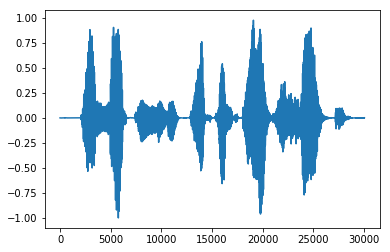

In [0]:
import matplotlib.pyplot as plt

# plot raw waveform
plt.plot(signal)
print('Shape of signal: {}'.format(signal.shape))

This gives us the signal in the so-called time-domain (signal over time).

![alt text](https://storage.googleapis.com/deepmind-live-cms/documents/BlogPost-Fig1-Anim-160908-r01.gif)

### Frequency Domain

Besides the time-domain (raw waveform), signals are often considered in their frequency domain.
The transformation is done by applying the (discrete) fourier transformation (DFT) to the signal (see [this tutorial](https://www.ritchievink.com/blog/2017/04/23/understanding-the-fourier-transform-by-example/) for details).
This splits the original waveform into its *sin/cos* components of different frequencies.
The result can be viewed as a spectrum of frequencies (i.e., **spectogram**). Audio processing libraries (e.g., speechpy or librosa) typically have their own implementations of the DFT, e.g. the fast fourier transform ([FFT](https://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/)), or build on top of numerical libraries such as numpy or scipy.

![alt text](https://www.ritchievink.com/img/post-5-fft/fig_2.png)

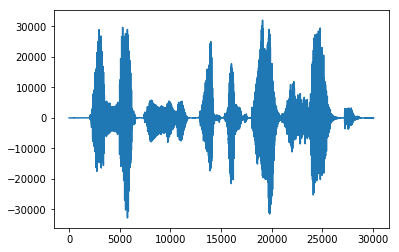

In [0]:
from scipy.io import wavfile as wav

# read .wav file with scipy
sr, signal = wav.read('emodb/wav/03a01Wa.wav')
plt.plot(signal)

<BarContainer object of 15022 artists>

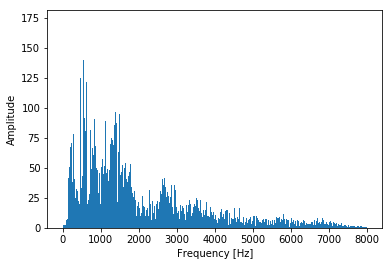

In [0]:
import numpy as np

# perform FFT on signal
fft = np.fft.fft(signal)

# get length of signal
N = signal.size

# equally spaced intervals (max. frequency is N-1)
f = np.linspace(0, sr, N)

# plot frequency spectrum (w.r.t. Nyquist frequency >= 2 * max. natural frequency)
plt.ylabel("Amplitude")
plt.xlabel("Frequency [Hz]")
plt.bar(f[:N // 2], np.abs(fft)[:N // 2] * 1 / N, width=1.5)  # 1 / N is a normalization factor

### Spectograms

As music or speech is often highly non-stationary, it is not very useful to compute a single fourier transform on the entire signal. To better reflect changes in the frequency-domain over time, it is useful to split the audio signal into successive frames and compute the FFT on them. This process is referred to as the [Short-time Fourier Transform (STFT)](https://musicinformationretrieval.com/stft.html). The result can be viewed as a spectogram (sort of a heatmap), where the x-axis is the time and the y-axis reflects the prevalent frequencies in the signal with their respective powers (value of each (x,y)-tuple).

In [0]:
# load audio file into signal (np.ndarray) and sampling rate
signal, sr = librosa.load(path='emodb/wav/03a01Wa.wav', sr=16000)

# STFT
# hop_length: sliding window step size
hop_length = 512
print('hop_length: {} seconds'.format(float(hop_length)/sr)) # units of seconds

# n_fft: frame size, i.e., amount of samples to use for computing FFT
n_fft = 2048
print('n_fft: {} seconds'.format(float(n_fft)/sr)) # units of seconds

# compute STFT using librosa
X = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
print('STFT has {} frequency bins and {} frames in time'.format(X.shape[0], X.shape[1]))

hop_length: 0.032 seconds
n_fft: 0.128 seconds
STFT has 1025 frequency bins and 59 frames in time


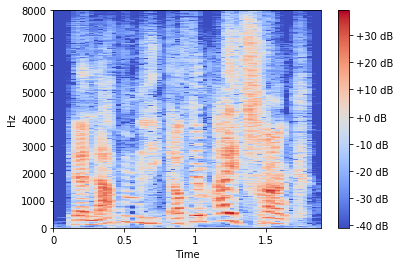

In [0]:
from librosa.display import specshow
# human perception of sound intensity is logarithmic in nature
# log amplitude of signal
S = librosa.amplitude_to_db(abs(X))

# plot spectogram
specshow(S, sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')

### Advanced Audio Features (using Mel Scale)

Mel Frequency Cepstral Coefficients (MFCCs) are a more compact representation of the STFT, which are derived by reducing and mapping the frequencies to the [mel scale](https://en.wikipedia.org/wiki/Mel_scale).
Advanced audio processing libraries such as [speechpy](https://speechpy.readthedocs.io/en/latest/content/features.html#mfcc) and [librosa](http://librosa.github.io/librosa/) provide useful methods to extract either mel scaled spectograms or other feature representations (e.g., MFCCs) of audio signals. These can be fed into both, classical machine learning models or neural networks.

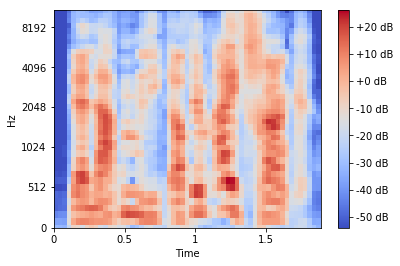

In [0]:
# number of mel bands to generate
n_mels = 40

# compute mel-scale spectogram
S = librosa.feature.melspectrogram(y=signal,
                                   sr=sr, 
                                   n_fft=n_fft, 
                                   hop_length=hop_length,
                                   n_mels=n_mels)
# log amplitude
S = librosa.power_to_db(S)

# plot spectogram
specshow(S, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

(39, 59)


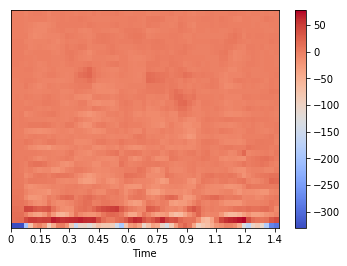

In [0]:
# number of MFCCs to return
n_mfcc = 39

# compute MFCCs
mfccs = librosa.feature.mfcc(y=signal, 
                             sr=sr, 
                             n_mfcc=n_mfcc, 
                             hop_length=hop_length,
                             n_fft=n_fft,
                             n_mels=n_mels)

# plot MFCCs
specshow(mfccs, x_axis='time')
plt.colorbar()
print(mfccs.shape)

In [0]:
%%capture
!pip install speechpy

(54, 39)


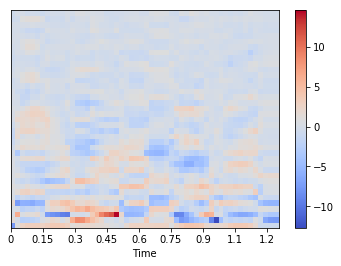

In [0]:
# alternative using speechpy
import speechpy

# define frame size and stride
frame_length = n_fft / sr
frame_stride = hop_length / sr

# compute MFCCs
mfccs = speechpy.feature.mfcc(signal=signal, 
                      sampling_frequency=sr, 
                      frame_length=frame_length,
                      frame_stride=frame_stride,
                      fft_length=n_fft,
                      num_filters=n_mels,
                      num_cepstral=n_mfcc)

# plot MFCCs
specshow(mfccs.T, x_axis='time')
plt.colorbar()
print(mfccs.shape)

## Recurrent Neural Networks (RNNs)

RNNs, which were invented in the 1980s, can be interpreted as networks with memory, which capture information from previous inputs over long or short term ([Hopfield, 1982](https://bi.snu.ac.kr/Courses/g-ai09-2/hopfield82.pdf)). This makes them very useful when working with sequential data such as audio signals, video frames, or written text, also more generally time series data.
The figure below illustrates an unrolled RNN network where $x_t$ denotes the input at timestep $t$, $A$ depicts the hidden layer of a single recurrent unit (i.e., neuron), and $h_t$ is the output activation at timestep $t$ (see [this blog post](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) for a more detailed explanation).

![rnn](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png)

Vanilla RNNs lack the capability to learn long-term dependencies due to the vanishing gradient problem.
Neural networks based on Long-short term units (LSTMs) solve this problem ([Hochreiter and Schmidhuber, 1991](http://people.idsia.ch/~juergen/SeppHochreiter1991ThesisAdvisorSchmidhuber.pdf)). They have inherent gates which allow them to retain information also over long periods of time.
The following figure shows the inner of an LSTM unit.

![lstm](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)

Gated Recurrent Units (GRUs) are an alternative to LSTMs with a slightly different architecture, which have also proven to be very powerful capturing long-term dependencies in sequences ([Cho et al., 2014](https://arxiv.org/pdf/1406.1078.pdf)).

### Preparing the Dataset for a Classification Task

First we put the `.wav` files into directories corresponding to their labelled emotion.
Result:
```
- emodb
  - data
    - angry
      - 03a01Wa.wav
      - ...
    - boredom
      - 03a04Lc.wav
      - ...
    - ...
```

In [0]:
import os
from shutil import copyfile

# `.wav` files are named as: 
# Positions 1-2: number of speaker
# Positions 3-5: code for text
# Position 6: emotion (sorry, letter stands for german emotion word)
# Position 7: if there are more than two versions these are numbered a, b, c

emotions = {
    'W':'anger', 
    'L':'boredom', 
    'E':'disgust', 
    'A':'fear', 
    'F':'happiness', 
    'T':'sadness', 
    'N':'neutral'
}

# create dirs for emotions
base_path = 'emodb/data'
for e in emotions.values():
  directory = os.path.join(base_path, e)
  if not os.path.exists(directory):
    os.makedirs(directory)

# put .wav files into respective directories
wav_path = 'emodb/wav'
for file in os.listdir(path=wav_path):
  dst = os.path.join(base_path, emotions[file[-6]], file)
  copyfile(os.path.join(wav_path, file), dst)

In [0]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [0]:
# tf.enable_eager_execution() # facilitates using `tf.data` APIs
print(tf.__version__)

1.13.1


In [0]:
np.random.seed(42)
tf.set_random_seed(42)

### Create train/test Dataset

1. Iterate through directories
2. Read audio files
3. Extract MFCCs for each file
4. Store MFCCs + label into `(X, y)`
5. Split into train and test datasets (train: 80% / test: 20%)

In [0]:
def preprocess_audio_file(filepath, 
                          n_mfcc=39,
                          raw_audio=False,
                          spectogram=False):
    """
    Preprocess audio file
    
    :param filepath: path to .wav-file
    :param n_mfcc: Number of mfcc features to take for each frame (e.g., for RNN)
    :param raw_audio: Whether to return raw audio signal (e.g., for Conv1D neural network)
    :param spectogram: Whether to return a melspectogram (e.g., for Conv2D neural network)

    :return feature vector from mfcc
    """
    signal, sr = librosa.load(path=filepath, sr=16000)
    s_len = len(signal)
    
    # empirically calculated mean length for the given data set (2 seconds)
    mean_signal_length = 32000

    # pad/slice the signals to have same size if lesser than required
    if s_len < mean_signal_length:
        pad_len = mean_signal_length - s_len
        pad_rem = pad_len % 2
        pad_len //= 2
        signal = np.pad(signal, (pad_len, pad_len + pad_rem),
                        'constant', constant_values=0)
    else:
        pad_len = s_len - mean_signal_length
        pad_len //= 2
        signal = signal[pad_len:pad_len + mean_signal_length]
    
    # return raw audio signal
    if raw_audio:
      return signal

    # parameters for STFT
    n_fft = 512
    n_mels = 40
    hop_length = 256
    frame_length = n_fft / sr
    frame_stride = hop_length / sr
    
    # compute mel scale spectogram
    if spectogram:
      S = librosa.feature.melspectrogram(y=signal, 
                                         sr=sr, 
                                         n_fft=n_fft, 
                                         hop_length=hop_length,
                                         n_mels=n_mels)
      S = librosa.power_to_db(S)
      return S
    
    # compute MFCCs
    mfccs = speechpy.feature.mfcc(signal=signal, 
                                  sampling_frequency=sr, 
                                  frame_length=frame_length,
                                  frame_stride=frame_stride,
                                  fft_length=n_fft,
                                  num_filters=n_mels,
                                  num_cepstral=n_mfcc)
    return mfccs

In [0]:
def get_train_test_split(path, 
                         class_labels,
                         n_mfcc=39,
                         raw_audio=False,
                         spectogram=False,
                         test_size=0.2):
    """
    Extract data for training and testing.
    
    :param path: directory to files
    :param class_labels: list of labels
    :param n_mfcc: Number of mfcc features to take for each frame
    :param raw_audio: Whether to use raw audio signal
    :param spectogram: Whether to use melspectograms
    :param test_size: Fraction of data to use for testing

    :return X_train, y_train, X_test, y_test (feature vectors with labels)
    """
    data = []
    labels = []
    
    # iterate over audio files and get mfcc feature vector
    for i, label in enumerate(class_labels):
        directory = os.path.join(path, label)
        for filename in os.listdir(directory):
            filepath = os.path.join(directory, filename)
            feature_vector = preprocess_audio_file(filepath=filepath,
                                                   raw_audio=raw_audio,
                                                   spectogram=spectogram,
                                                   n_mfcc=n_mfcc)
            data.append(feature_vector)
            labels.append(i)

    # split into train/test
    data = np.array(data)
    labels = np.array(labels)
    labels = tf.keras.utils.to_categorical(y=labels, num_classes=len(class_labels), dtype=int)
    
    X_train, X_test, y_train, y_test = train_test_split(
        data,
        labels,
        stratify=labels,
        test_size=test_size,
        shuffle=True,
        random_state=42)

    return X_train, X_test, y_train, y_test

In [0]:
X_train, X_test, y_train, y_test = get_train_test_split('emodb/data', 
                                                        emotions.values())

In [0]:
print('Shape of X_train: {} -> (num_samples, num_timesteps, num_features)'.format(X_train.shape))
print('Shape of y_train: {} -> (num_samples, num_classes)'.format(y_train.shape))

Shape of X_train: (428, 123, 39) -> (num_samples, num_timesteps, num_features)
Shape of y_train: (428, 7) -> (num_samples, num_classes)


### Training RNN model on MFCCs

We define a simple LSTM model with one hidden layer of 128 LSTM units and two dense layers before classifying into the 7 emotions using a softmax output layer.

In [0]:
from tensorflow.keras.layers import LSTM, CuDNNGRU, Dropout, Dense

In [0]:
def build_rnn_model(input_shape, num_classes):
  model = tf.keras.Sequential([
    LSTM(128, input_shape=input_shape),
    # CuDNNGRU(128, input_shape=input_shape), # high performant alternative to LSTMs
    Dropout(rate=0.5),
    Dense(32, activation='relu'),
    Dense(16, activation='tanh'),
    Dense(num_classes, activation='softmax')
  ])

  model.compile(loss='categorical_crossentropy',
                optimizer='adam', 
                metrics=['accuracy'])
  print(model.summary())
  return model

In [0]:
model = build_rnn_model((X_train.shape[1], X_train.shape[2]), y_train.shape[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               86016     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_11 (Dense)             (None, 7)                 119       
Total params: 90,791
Trainable params: 90,791
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
model.fit(x=X_train,
          y=y_train, 
          shuffle=True,
          batch_size=32,
          epochs=20,
          validation_data=(X_test, y_test))

Train on 428 samples, validate on 107 samples
Epoch 1/20
428/428 [==============================] - 4s 9ms/sample - loss: 1.9766 - acc: 0.1799 - val_loss: 1.8316 - val_acc: 0.1776
Epoch 2/20
428/428 [==============================] - 4s 8ms/sample - loss: 1.7813 - acc: 0.2804 - val_loss: 1.7489 - val_acc: 0.2897
Epoch 3/20
428/428 [==============================] - 4s 8ms/sample - loss: 1.7112 - acc: 0.3435 - val_loss: 1.6608 - val_acc: 0.3271
Epoch 4/20
428/428 [==============================] - 3s 8ms/sample - loss: 1.6057 - acc: 0.3832 - val_loss: 1.5685 - val_acc: 0.3832
Epoch 5/20
428/428 [==============================] - 3s 7ms/sample - loss: 1.4724 - acc: 0.4509 - val_loss: 1.4613 - val_acc: 0.4579
Epoch 6/20
428/428 [==============================] - 3s 7ms/sample - loss: 1.3783 - acc: 0.4766 - val_loss: 1.3409 - val_acc: 0.4860
Epoch 7/20
428/428 [==============================] - 3s 7ms/sample - loss: 1.2737 - acc: 0.5117 - val_loss: 1.2906 - val_acc: 0.5327
Epoch 8/20
428/4

### Evaluation of Model Performance

We evaluate the model performance by looking at a straightforward medium, the confusion matrix.

In [0]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(confusion_matrix, class_names):
    """
    Prints a confusion matrix
    
    :param confusion_matrix: matrix returned by `sklearn.metrics.confusion_matrix`
    :param class_names: list of class names
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig, ax = plt.subplots(figsize=(12,8))
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", ax=ax)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

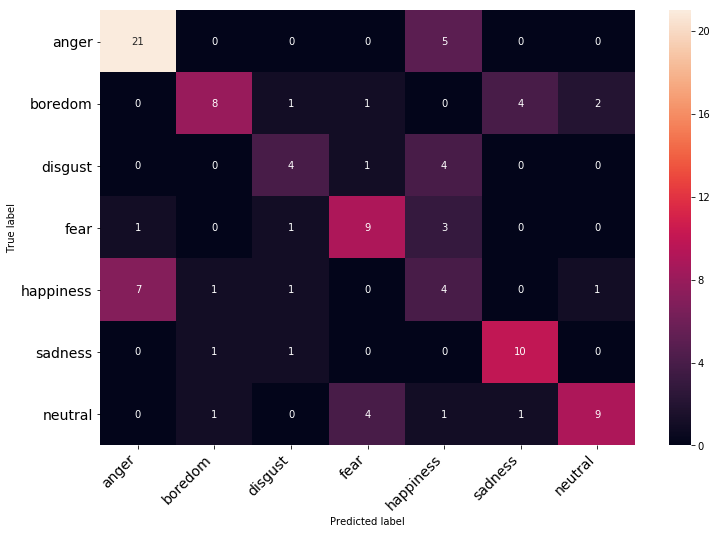

In [0]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_true=np.argmax(y_test, axis=1), 
                      y_pred=np.argmax(y_pred, axis=1))
print_confusion_matrix(cm, emotions.values())

In [0]:
filename = 'emodb/data/anger/03a01Wa.wav'
sample = preprocess_audio_file(filename)
prediction = np.argmax(model.predict(np.array([sample])))
print('Prediction: {}, Actual: {}'.format(prediction, 0)) # emotions are 0-indexed

Prediction: 0, Actual: 0
